In [8]:
# --- CONFIG ---
CSV_PATH = r"C:\Users\Vex\Desktop\football\dataset\matchday\clean_matchday_stat.csv"
TEAM_HINTS = ["Leverkusen", "Bayern"]  # reporting order
MATCH_DURATION = 96.0                  # analysis horizon per match (min)

import re
import numpy as np
import pandas as pd

df = pd.read_csv(CSV_PATH)


In [9]:
# Resolve likely column names (best-effort)
aliases = {
    "home_team": ["home_team","HomeTeam","home","Home"],
    "away_team": ["away_team","AwayTeam","away","Away"],
    "home_goal_times": ["home_team_goals_current_time","home_goals_times","home_goals_time"],
    "away_goal_times": ["away_team_goals_current_time","away_goals_times","away_goals_time"],
}
res = {}
for k, opts in aliases.items():
    for c in opts:
        if c in df.columns:
            res[k] = c
            break

need = ["home_team","away_team","home_goal_times","away_goal_times"]
missing = [k for k in need if k not in res]
if missing:
    raise ValueError(f"Missing required columns: {missing}. Resolved={res}")

H, A = res["home_team"], res["away_team"]
GTH, GTA = res["home_goal_times"], res["away_goal_times"]

def parse_minute_list(cell):
    """Parse strings like ["7'", "45+2'", "90+4'"] → [7, 47, 94]; clamp to MATCH_DURATION."""
    if pd.isna(cell):
        return []
    s = str(cell)
    mins = []
    for m in re.findall(r"(\d+)(?:\+(\d+))?'", s):
        base = int(m[0]); plus = int(m[1]) if m[1] not in (None,'') else 0
        mins.append(base + plus)
    return [int(x) for x in mins if 0 <= x <= MATCH_DURATION]


In [10]:
# Team selection by simple substring match
all_teams = sorted(set(df[H].dropna().unique()).union(set(df[A].dropna().unique())))
def pick_team(hint):
    cand = [t for t in all_teams if hint.lower() in str(t).lower()]
    return cand[0] if cand else None

TEAMS = []
for hint in TEAM_HINTS:
    t = pick_team(hint)
    if t is None:
        raise RuntimeError(f"Could not find a team for hint '{hint}'. Available examples: {all_teams[:8]}")
    TEAMS.append(t)

def build_events_for_team(TEAM):
    """For a given team, return match-level arrays: [team_goal_minutes, opp_goal_minutes]."""
    evs = []
    for _, r in df.iterrows():
        home, away = r[H], r[A]
        if home == TEAM or away == TEAM:
            g_home = parse_minute_list(r[GTH])
            g_away = parse_minute_list(r[GTA])
            if home == TEAM:
                ev_team = np.array(sorted(g_home), dtype=float)
                ev_opp  = np.array(sorted(g_away), dtype=float)
            else:
                ev_team = np.array(sorted(g_away), dtype=float)
                ev_opp  = np.array(sorted(g_home), dtype=float)
            ev_team = ev_team[(ev_team >= 0) & (ev_team <= MATCH_DURATION)]
            ev_opp  = ev_opp[(ev_opp  >= 0) & (ev_opp  <= MATCH_DURATION)]
            evs.append([ev_team, ev_opp])
    return evs

events_by_team = {TEAM: build_events_for_team(TEAM) for TEAM in TEAMS}
for TEAM in TEAMS:
    print(f"{TEAM}: built {len(events_by_team[TEAM])} matches with goal times.")


Bayer Leverkusen: built 34 matches with goal times.
Bayern Munich: built 34 matches with goal times.


In [11]:
# Proportion tests using precomputed totals
import numpy as np
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

n_lev, n_bay = 113, 139  # totals as reported

def two_prop(label, lev_pct, bay_pct, same_team=False):
    """One-sided z-test (Bayern > Leverkusen); prints counts, CIs, and risk ratio."""
    lev_k = int(round(lev_pct/100 * n_lev))
    bay_k = int(round(bay_pct/100 * n_bay))
    stat, p = proportions_ztest(count=[bay_k, lev_k], nobs=[n_bay, n_lev], alternative="larger")
    ci_bay = proportion_confint(bay_k, n_bay, method="wilson")
    ci_lev = proportion_confint(lev_k, n_lev, method="wilson")
    rr = (bay_pct / lev_pct) if lev_pct > 0 else np.nan
    kind = "same-team" if same_team else "any-team"
    print(f"{label} ({kind}): BAY {bay_k}/{n_bay} ({bay_pct:.1f}%, CI {ci_bay[0]*100:.1f}-{ci_bay[1]*100:.1f})  |  "
          f"LEV {lev_k}/{n_lev} ({lev_pct:.1f}%, CI {ci_lev[0]*100:.1f}-{ci_lev[1]*100:.1f})  "
          f"RR≈{rr:.2f},  one-sided p={p:.4f}")

# ANY-TEAM follow-ups
two_prop("3 min",  3.5,  7.2)
two_prop("5 min",  8.8, 17.3)
two_prop("10 min", 26.5, 36.0)
two_prop("15 min", 36.3, 41.7)

# SAME-TEAM follow-ups (momentum)
two_prop("3 min",  2.7,  2.2, same_team=True)
two_prop("5 min",  4.4, 11.5, same_team=True)
two_prop("10 min", 16.8, 26.6, same_team=True)
two_prop("15 min", 28.3, 30.2, same_team=True)


3 min (any-team): BAY 10/139 (7.2%, CI 4.0-12.7)  |  LEV 4/113 (3.5%, CI 1.4-8.7)  RR≈2.06,  one-sided p=0.1039
5 min (any-team): BAY 24/139 (17.3%, CI 11.9-24.4)  |  LEV 10/113 (8.8%, CI 4.9-15.5)  RR≈1.97,  one-sided p=0.0259
10 min (any-team): BAY 50/139 (36.0%, CI 28.5-44.2)  |  LEV 30/113 (26.5%, CI 19.3-35.4)  RR≈1.36,  one-sided p=0.0550
15 min (any-team): BAY 58/139 (41.7%, CI 33.9-50.0)  |  LEV 41/113 (36.3%, CI 28.0-45.5)  RR≈1.15,  one-sided p=0.1894
3 min (same-team): BAY 3/139 (2.2%, CI 0.7-6.2)  |  LEV 3/113 (2.7%, CI 0.9-7.5)  RR≈0.81,  one-sided p=0.6015
5 min (same-team): BAY 16/139 (11.5%, CI 7.2-17.9)  |  LEV 5/113 (4.4%, CI 1.9-9.9)  RR≈2.61,  one-sided p=0.0215
10 min (same-team): BAY 37/139 (26.6%, CI 20.0-34.5)  |  LEV 19/113 (16.8%, CI 11.0-24.8)  RR≈1.58,  one-sided p=0.0313
15 min (same-team): BAY 42/139 (30.2%, CI 23.2-38.3)  |  LEV 32/113 (28.3%, CI 20.8-37.2)  RR≈1.07,  one-sided p=0.3711


In [12]:
# Momentum after a team's own goals: setup (kept separate for clarity)
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint, proportions_ztest

# Resolve columns (minimal pick)
def pick(cols):
    for c in cols:
        if c in df.columns: return c
    return None

COL_TH = pick(["home_team","HomeTeam","home","Home"])
COL_TA = pick(["away_team","AwayTeam","away","Away"])
COL_GH = pick(["home_team_goals_current_time","home_goals_times","home_goal_times"])
COL_GA = pick(["away_team_goals_current_time","away_goals_times","away_goal_times"])
if not all([COL_TH, COL_TA, COL_GH, COL_GA]):
    raise ValueError(f"Missing needed columns. Resolved: TH={COL_TH}, TA={COL_TA}, GH={COL_GH}, GA={COL_GA}")

def parse_goal_minutes(cell):
    """Parse goal strings like 45', 90+2' (with bare-number fallback) to minutes within 0–120."""
    s = "" if pd.isna(cell) else str(cell)
    mins = []
    for m in re.findall(r"(\d+)(?:\+(\d+))?'", s):
        base = int(m[0]); plus = int(m[1]) if m[1] not in (None,'') else 0
        mins.append(base + plus)
    if "'" not in s:
        for m in re.findall(r"\b(\d{1,2})(?:\+(\d{1,2}))?\b", s):
            base = int(m[0]); plus = int(m[1]) if m[1] not in (None,'') else 0
            if base <= 120: mins.append(base + plus)
    mins = [x for x in mins if 0 <= x <= 120]
    return sorted(mins)


In [13]:
# Per-match rows then long format from each team's perspective
rows = []
for _, r in df.iterrows():
    rows.append({
        "home": r[COL_TH], "away": r[COL_TA],
        "gh": parse_goal_minutes(r[COL_GH]),
        "ga": parse_goal_minutes(r[COL_GA]),
    })
matches = pd.DataFrame(rows)

long = pd.DataFrame({
    "team": matches["home"].tolist() + matches["away"].tolist(),
    "opp":  matches["away"].tolist() + matches["home"].tolist(),
    "tg":   matches["gh"].tolist()   + matches["ga"].tolist(),
    "og":   matches["ga"].tolist()   + matches["gh"].tolist(),
})

# Choose team names from table (fallbacks preserved)
def pick_team_name(names, hint):
    m = [t for t in names if isinstance(t,str) and hint.lower() in t.lower()]
    return m[0] if m else None

teams_all = sorted(long["team"].dropna().unique())
TEAM_A = pick_team_name(teams_all, "Leverkusen") or "Bayer Leverkusen"
TEAM_B = pick_team_name(teams_all, "Bayern")     or "Bayern Munich"

def our_vs_opp_followups_after_own_goals(team_name, windows=(3,5,10,15)):
    """For each own goal, count next goal by same team vs opponent within time windows."""
    sub = long[long["team"]==team_name]
    our_counts  = {w:0 for w in windows}
    opp_counts  = {w:0 for w in windows}
    total_triggers = 0

    for _, r in sub.iterrows():
        tg, og = r["tg"], r["og"]
        for t in tg:
            total_triggers += 1
            for w in windows:
                if any((g>t and g<=t+w) for g in tg): our_counts[w] += 1
                if any((g>t and g<=t+w) for g in og): opp_counts[w] += 1

    our_pct = {w: (our_counts[w]/max(total_triggers,1))*100 for w in windows}
    opp_pct = {w: (opp_counts[w]/max(total_triggers,1))*100 for w in windows}
    return our_counts, opp_counts, total_triggers, our_pct, opp_pct

windows = [3,5,10,15]
A_our_k, A_opp_k, A_N, A_our_pct, A_opp_pct = our_vs_opp_followups_after_own_goals(TEAM_A, windows)
B_our_k, B_opp_k, B_N, B_our_pct, B_opp_pct = our_vs_opp_followups_after_own_goals(TEAM_B, windows)

# Text summary
print(f"{TEAM_A}: triggers (total goals) = {A_N}")
for w in windows:
    print(f"  {w:>2}′ → OUR: {A_our_k[w]}/{A_N} ({A_our_pct[w]:.1f}%),  OPP: {A_opp_k[w]}/{A_N} ({A_opp_pct[w]:.1f}%)")
print(f"\n{TEAM_B}: triggers (total goals) = {B_N}")
for w in windows:
    print(f"  {w:>2}′ → OUR: {B_our_k[w]}/{B_N} ({B_our_pct[w]:.1f}%),  OPP: {B_opp_k[w]}/{B_N} ({B_opp_pct[w]:.1f}%)")


Bayer Leverkusen: triggers (total goals) = 89
   3′ → OUR: 3/89 (3.4%),  OPP: 0/89 (0.0%)
   5′ → OUR: 3/89 (3.4%),  OPP: 4/89 (4.5%)
  10′ → OUR: 14/89 (15.7%),  OPP: 9/89 (10.1%)
  15′ → OUR: 23/89 (25.8%),  OPP: 10/89 (11.2%)

Bayern Munich: triggers (total goals) = 94
   3′ → OUR: 2/94 (2.1%),  OPP: 4/94 (4.3%)
   5′ → OUR: 14/94 (14.9%),  OPP: 6/94 (6.4%)
  10′ → OUR: 29/94 (30.9%),  OPP: 8/94 (8.5%)
  15′ → OUR: 33/94 (35.1%),  OPP: 14/94 (14.9%)


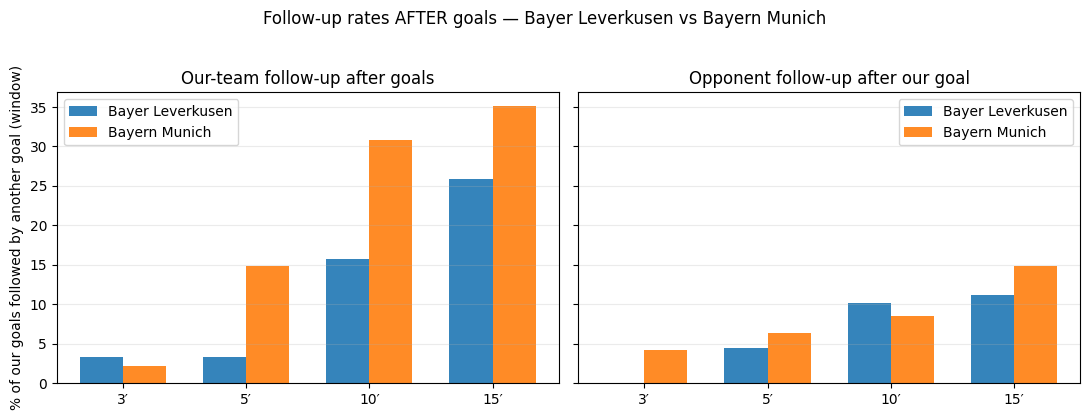


— Z-tests (one-sided, Bayern > Leverkusen) —
3′ OUR-follow-up: p=0.6969
5′ OUR-follow-up: p=0.0036
10′ OUR-follow-up: p=0.0079
15′ OUR-follow-up: p=0.0870
3′ OPP-follow-up: p=0.0246
5′ OPP-follow-up: p=0.2871
10′ OPP-follow-up: p=0.6455
15′ OPP-follow-up: p=0.2319


In [14]:
# Bar charts with simple CIs (Wilson)
def k_to_pct_ci(k, n):
    pct = (np.array(k)/max(n,1))*100.0
    lo, hi = proportion_confint(np.array(k), n, method="wilson")
    return pct, lo*100.0, hi*100.0

lev_our_pct,  lev_our_lo,  lev_our_hi  = k_to_pct_ci([A_our_k[w] for w in windows], A_N)
lev_opp_pct,  lev_opp_lo,  lev_opp_hi  = k_to_pct_ci([A_opp_k[w] for w in windows], A_N)
bay_our_pct,  bay_our_lo,  bay_our_hi  = k_to_pct_ci([B_our_k[w] for w in windows], B_N)
bay_opp_pct,  bay_opp_lo,  bay_opp_hi  = k_to_pct_ci([B_opp_k[w] for w in windows], B_N)

import matplotlib.pyplot as plt
x = np.arange(len(windows))
wbar = 0.35
fig, axes = plt.subplots(1, 2, figsize=(11,4), sharey=True)

# (a) Same-team follow-up after own goals
ax = axes[0]
ax.bar(x - wbar/2, lev_our_pct, width=wbar, label=TEAM_A, alpha=0.9)
ax.bar(x + wbar/2, bay_our_pct, width=wbar, label=TEAM_B, alpha=0.9)
ax.set_xticks(x); ax.set_xticklabels([f"{m}′" for m in windows])
ax.set_ylabel("% of our goals followed by another goal (window)")
ax.set_title("Our-team follow-up after goals")
ax.grid(True, axis="y", alpha=0.25); ax.legend()

# (b) Opponent follow-up after our own goals
ax = axes[1]
ax.bar(x - wbar/2, lev_opp_pct, width=wbar, label=TEAM_A, alpha=0.9)
ax.bar(x + wbar/2, bay_opp_pct, width=wbar, label=TEAM_B, alpha=0.9)
ax.set_xticks(x); ax.set_xticklabels([f"{m}′" for m in windows])
ax.set_title("Opponent follow-up after our goal")
ax.grid(True, axis="y", alpha=0.25); ax.legend()

fig.suptitle(f"Follow-up rates AFTER goals — {TEAM_A} vs {TEAM_B}", y=1.03)
plt.tight_layout(); plt.show()

# Optional: one-sided tests (Bayern > Leverkusen)
print("\n— Z-tests (one-sided, Bayern > Leverkusen) —")
for w in windows:
    stat, p = proportions_ztest([B_our_k[w], A_our_k[w]], [B_N, A_N], alternative="larger")
    print(f"{w}′ OUR-follow-up: p={p:.4f}")
for w in windows:
    stat, p = proportions_ztest([B_opp_k[w], A_opp_k[w]], [B_N, A_N], alternative="larger")
    print(f"{w}′ OPP-follow-up: p={p:.4f}")
